In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# eztao imports
import eztao
from eztao.carma import DHO_term, CARMA_term, DRW_term
from eztao.ts import gpSimFull, gpSimByTime, addNoise
from eztao.ts.carma_fit import sample_carma

from tape.ensemble import Ensemble
from tape.utils import ColumnMapper
from tape.analysis import calc_sf2

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.adapt(minimum=1, maximum=40) 

ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()


/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36004 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36004/status,
Dashboard: http://127.0.0.1:36004/status,Workers: 8
Total threads: 64,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45203,Workers: 8
Dashboard: http://127.0.0.1:36004/status,Total threads: 64
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:37586,Total threads: 8
Dashboard: http://127.0.0.1:44196/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:43154,


In [5]:
# if running on baldur
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=True)

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/core.py:5243: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/core.py:5243: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
2023-10-10 15:47:42,987 - distributed.core - INFO - Connection to tcp://127.0.0.1:45203 has been closed.
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: P

# 0. Estimate noise for ztf 

In [19]:
ens.query("band_ztf_source == 'g'", table = 'source')
ens._source.compute()

,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,kronFluxErr_ps_source,infoFlag_ps_source,infoFlag2_ps_source,infoFlag3_ps_source,Norder_ps_source,Dir_ps_source,Npix_ps_source,Norder,Dir,provenance
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
024300.73+010915.0,4997869293954662400,4240,55455,822,40.753060,1.154190,4240-55455-0822,BOSS,2.474,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024300.73+010915.0,4997869293954662400,4240,55455,822,40.753060,1.154190,4240-55455-0822,BOSS,2.474,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024300.73+010915.0,4997869293954662400,4240,55455,822,40.753060,1.154190,4240-55455-0822,BOSS,2.474,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1


/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


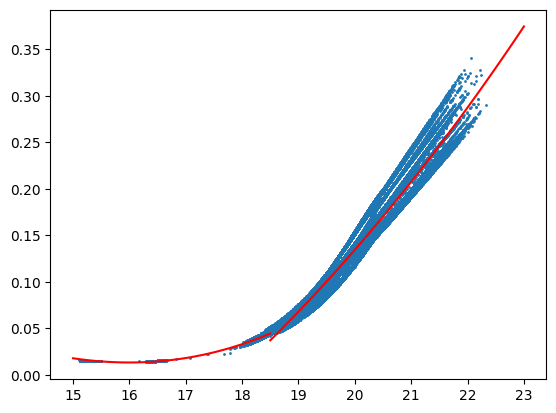

In [91]:
np.sort(ens._source['mag_ztf_source'].compute().values)

sort_array = np.argsort(ens._source['mag_ztf_source'].compute().values)
y = ens._source['mag_ztf_source'].compute().values[sort_array]
y_err = ens._source['magerr_ztf_source'].compute().values[sort_array]


g_polyfit_l18 = np.poly1d(np.polyfit(y[y<18.5] , y_err[y<18.5], deg=3))
g_polyfit_g18 = np.poly1d(np.polyfit(y[y>18.5] , y_err[y>18.5], deg=3))

x_l18 = np.linspace(15, 18.5, 100)
x_g18 = np.linspace(18.5, 23, 100)

plt.scatter(ens._source['mag_ztf_source'], ens._source['magerr_ztf_source'], s=1)
plt.plot(x_l18, g_polyfit_l18(x_l18), c='r')
plt.plot(x_g18, g_polyfit_g18(x_g18), c='r')

In [6]:
def err_func_f(mag):
    g_polyfit_l18 = np.poly1d([ 1.38997304e-04, -2.02030371e-03, -4.21095110e-02,  6.34775050e-01])
    g_polyfit_g18 = np.poly1d([ 4.82657946e-05,  3.96290863e-04, -4.04700576e-03, -3.29367881e-01])
    if mag <= 18.5:
        return g_polyfit_l18(mag)
    else:
        return g_polyfit_g18(mag)
    
v_err_func_f = np.vectorize(err_func_f)

In [20]:
name_str = '023922.87-000119.6'

ts_computed = ens._source.compute().loc[name_str]
ts_computed_g = ts_computed[ts_computed['band_ztf_source']=='g']
ts_computed_r = ts_computed[ts_computed['band_ztf_source']=='r']

ts = ens._source.compute().loc[name_str]
t_g = ts['mjd_ztf_source'].values
sort_array = np.argsort(t_g)
t_g = t_g[sort_array]
y_g = ts['mag_ztf_source'].values[sort_array]
yerr_g = ts['magerr_ztf_source'].values[sort_array]

In [21]:
t_start = np.min(ts_computed_g['mjd_ztf_source'].values)
tIn = np.sort(ts_computed_g['mjd_ztf_source'].values) - np.min(ts_computed_g['mjd_ztf_source'].values)
nLC = 100
SNR = 100

# define a DRW kernel
amp = 10**(-0.935381)
tau = 10**(2.749800)
DRW_kernel = DRW_term(np.log(amp), np.log(tau))

t, y, yerr = gpSimByTime(DRW_kernel , SNR, tIn, nLC=nLC, log_flux=True)
y = np.median(ts_computed_g['mag_ztf_source']) + y 

yerr = v_err_func_f(y)
# add noise
y = addNoise(y, yerr)


/tmp/ipykernel_95328/479826799.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(t_g, y_g, yerr=yerr_g, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')


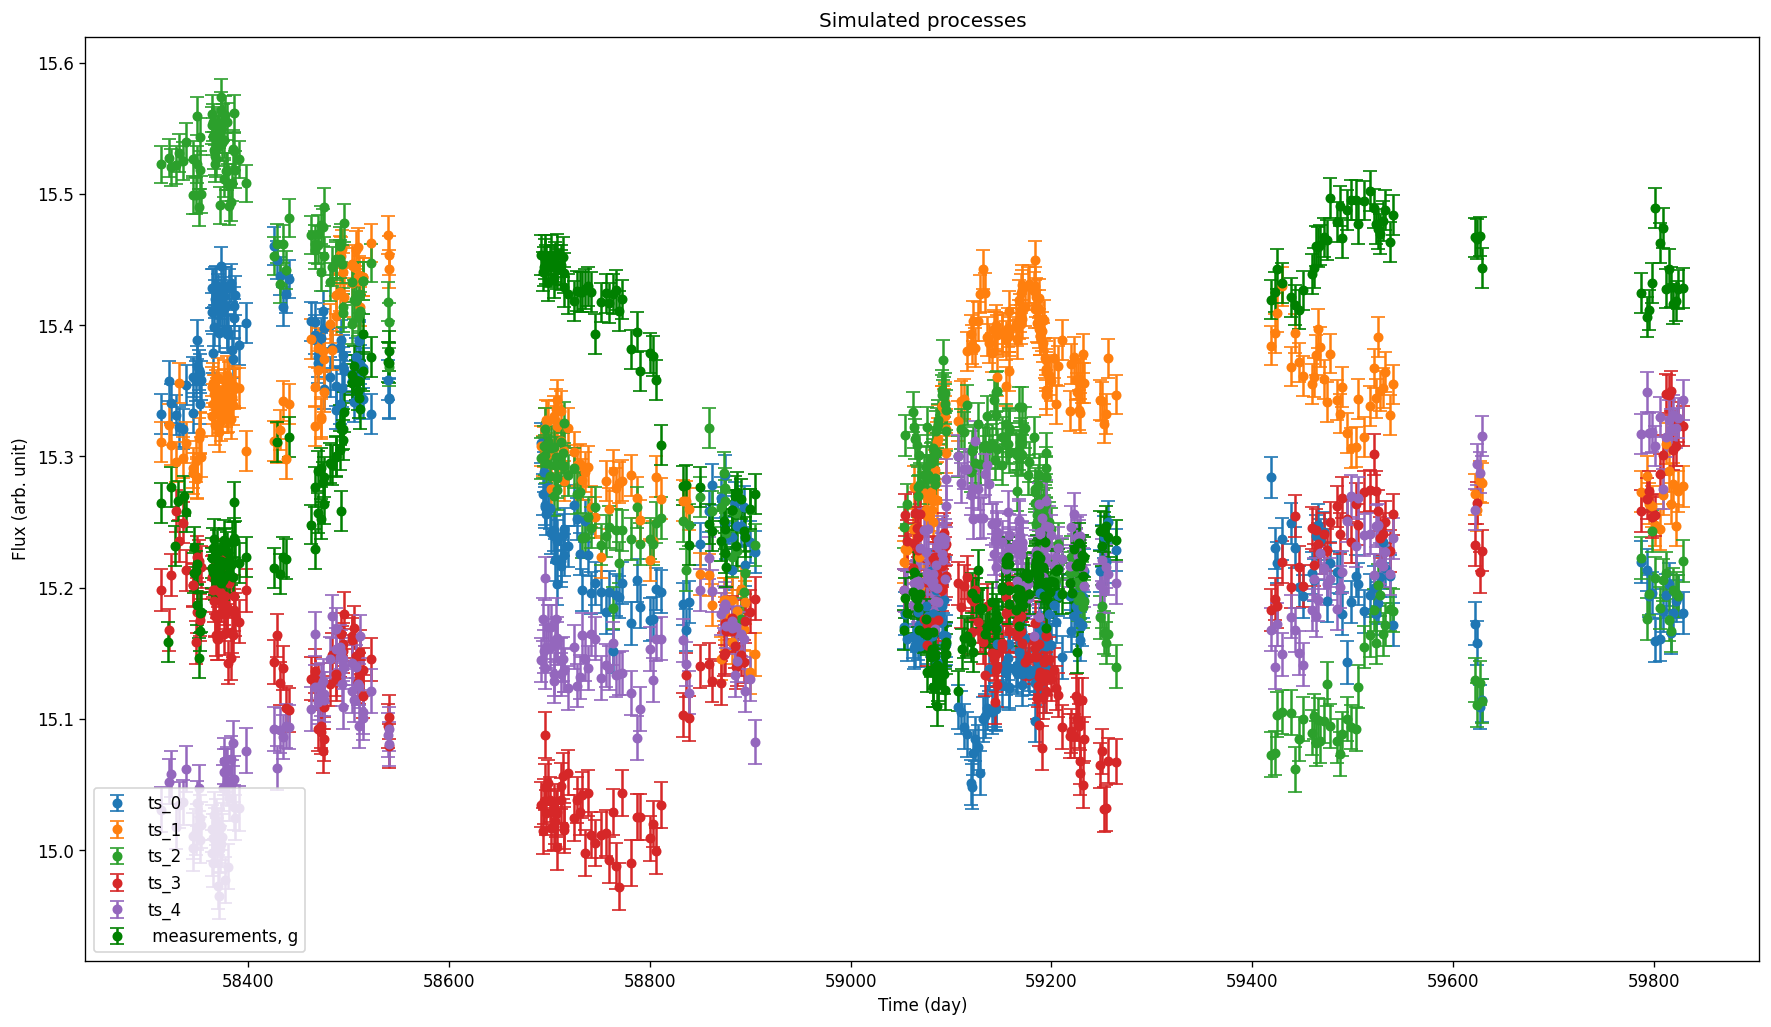

In [31]:
# plot the simulated process
fig, ax = plt.subplots(1,1, dpi=120, figsize=(18,10))

for i in range(nLC)[:5]:
    ax.errorbar(t[i]+t_start, y[i], yerr[i], fmt='.', label=f'ts_{i}', ms=10, capsize=4)
    
ax.errorbar(t_g, y_g, yerr=yerr_g, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')

ax.set_xlabel('Time (day)')
ax.set_ylabel('Flux (arb. unit)')
ax.set_title('Simulated processes')
ax.legend(markerscale=1, loc=3)

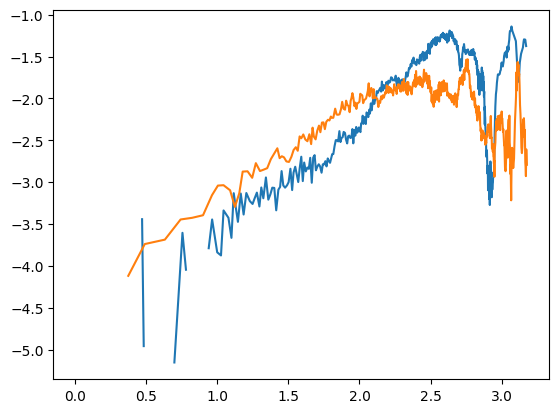

In [32]:
sf_real = calc_sf2(t_g, y_g, yerr_g)
sf_fake = calc_sf2(t[1], y[1], yerr[1])

plt.plot(np.log10(sf_real['dt']), np.log10(sf_real['sf2']))
plt.plot(np.log10(sf_fake['dt']), np.log10(sf_fake['sf2']))

In [35]:
df = pd.DataFrame({'time': t, 'mag': y, 'magerr': yerr}, index=range(len(t)))

ValueError: Data must be 1-dimensional, got ndarray of shape (100, 330) instead